# FDFD.jl

First, we need to import the `FDFD` and `FDFDViz` packages. These aren't registered in the Julia package manager so you will need to issue the commands:
```
Pkg.clone("https://github.com/ianwilliamson/FDFD.jl")
Pkg.clone("https://github.com/ianwilliamson/FDFDViz.jl")
```
The package `GeometryPrimitives`, available from https://github.com/stevengj/GeometryPrimitives.jl, can be used in addition to functions for setting the geometry. Technically this package is required by FDFD.jl, but you aren't required to use it to specify your geometry. If you wish you can also use functions.

Issue the command below to install the package **before** installing FDFD.jl:
```
Pkg.clone("https://github.com/stevengj/GeometryPrimitives.jl")
```

After the packages are installed, we can import them into our workspace:

In [ ]:
using FDFD, FDFDViz, GeometryPrimitives

The subsequent sections will provide a few working examples of using FDFD.jl.

If desired you can supress the text output from the solver issue the command:

In [ ]:
set_log_level!(0);

To enable the text output from the solver, issue the command:

In [ ]:
set_log_level!(1);

---

## Example 1: radiating dipole
As the heading suggestions, this demonstrates a simple radiating dipole in free space.

In [4]:
grid0 = Grid(0.02, [15 15], [-3 3], [-3 3]);
dev0  = Device(grid0, 2*π*200e12);
setup_src!(dev0, [0 0]);
field_dipole = solve(dev0);

Next, use the helper function `plot_field()` to display the radiated field. We can also use the `add_wavelengthbar()` function to overlay a scale bar and check that the wavelength of the radiated field is correct.

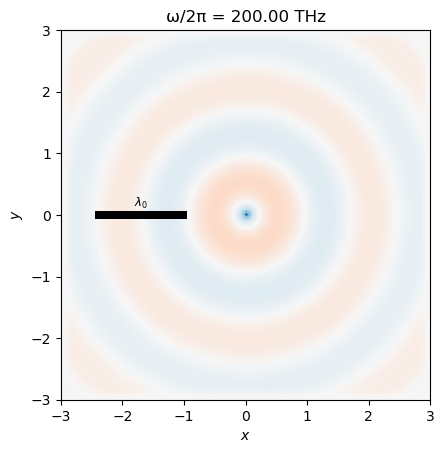

In [5]:
ax = plot_field(field_dipole, funcz=real)
add_wavelengthbar(ax, field_dipole, [-1.7, 0.0]);

---

## Example 2: straight waveguide
This example demonstrates launching a mode into a straight waveguide using a mode source. The solver uses the definition of the mode specified by `add_mode!(...)` to perform and eigenvalue solution of the waveguide. The calculated mode field is then launched into the waveguide.

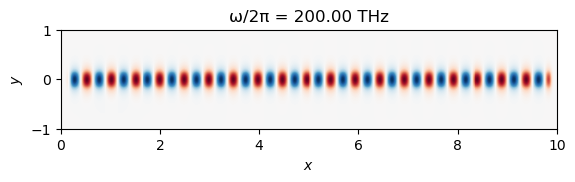

In [6]:
grd = Grid(0.02, [15, 10], [0.0, 10.0], [-1.0, 1.0]);
dev = Device(grd, 2*π*200e12);
setup_ϵᵣ!(dev, [Box([5.0, 0.0, 0.0], [Inf, 0.3, Inf], eye(3), 12)])
add_mode!(dev, Mode(TM, x̂, 3.5, [1.0 0], 0.8));
field = solve(dev);
plot_field(field);

---

## Example 3: Waveguide transition from dynamic modulation
This demonstrates an indirect photonic mode transition in a waveguide. The even mode is launched from the left and is converted to the odd mode as it propagates.

In [7]:
grid1 = Grid(0.01, [15 10], [0.0 15.0], [-1.0 1.0]);
dev1 = ModulatedDevice(grid1, 2π*1.939e14, 4.541e14, 1)

a = 0.2202;
q = 2.9263;

region_wg(x,y) = -a/2<=y<=a/2;
region_modulation(x,y) = 1.5<=x<=11.7 && -a/2<=y<=0;
modulation_function(x,y) = exp.(1im*q*x);

setup_ϵᵣ!(dev1, region_wg, 12.25);
setup_Δϵᵣ!(dev1, region_modulation, modulation_function);
add_mode!(dev1, Mode(TM, x̂, 3.5, [0.2, 0], 4*a));

field_transition = solve(dev1);

Note that the `add_mode!()` command allows us to specify a "slice" where the solver will perform a modal calculation to excite the 2D domain. We provide `add_mode!()` with a Mode struct that species the properties of this "slice" including the normal direction, the effective index of the mode, the center coordinates, and the width.

Next, use the helper function `plot_field()` to display the solved fields. This function should automatically handle the array of fields returned by `solve()` for the case of a modulated device. Each field corresponds to a different sideband.

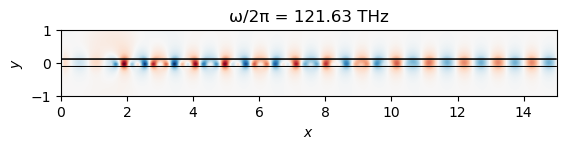

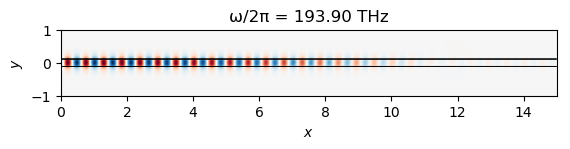

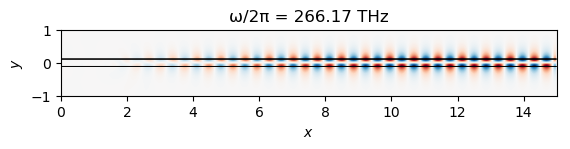

In [14]:
ax = plot_field.(field_transition, funcz=real);
plot_device.(ax, dev1, outline=true, lcm="none");

### Photon number calculation
Here we check photon number conservation. First calculate the input photon number.

In [9]:
Nin = flux_surface_integral(field_transition[2], [1.25, 0], Inf, x̂)/(2π*1.939e14)

1.362521601088891e-20

Then check the output photon number:

In [10]:
Nout = flux_surface_integral(field_transition[3], [11.95,0], Inf, x̂)/(4.541e14+2π*1.939e14)+
flux_surface_integral(field_transition[2], [11.95,0], Inf, x̂)/(2π*1.939e14)+
flux_surface_integral(field_transition[1], [11.95,0], Inf, x̂)/(2π*1.939e14-4.541e14)

1.361873101465099e-20

Finally, take the ratio. This should be very close to unity:

In [11]:
Nout/Nin

0.9995240445191667

---

## Example 4: Ring resonator modes

This example demonstrates the calculation of the eigenfrequencies of a ring resonator.

In [12]:
R1 = 1.0
W  = 0.2
Wx = 4.0
Wy = 4.0
grd = Grid(0.01, [15 15], [-Wx/2 Wx/2], [-Wy/2 +Wy/2]);
dev = Device(grd, 2*π*200e12);

shapes = [Cylinder([0,0,0], R1-W, [0,0,1], Inf, 1.0)]
append!(shapes, [Cylinder([0,0,0], R1, [0,0,1], Inf, 12.25)])
setup_ϵᵣ!(dev, shapes)

(ω, fields) = eigenfrequency(dev, TE, 4, which=:LR);

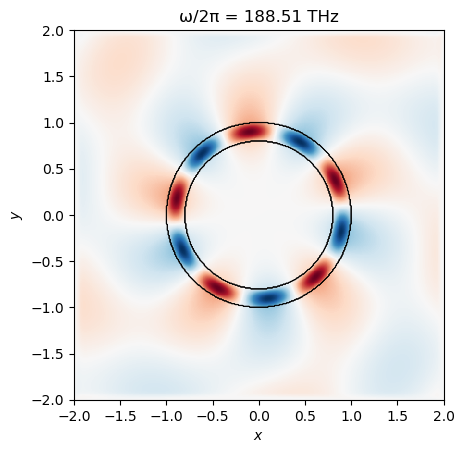

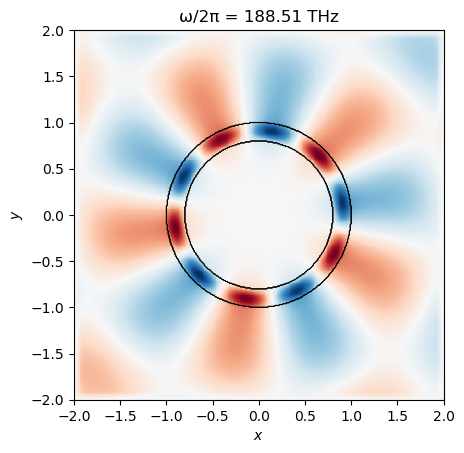

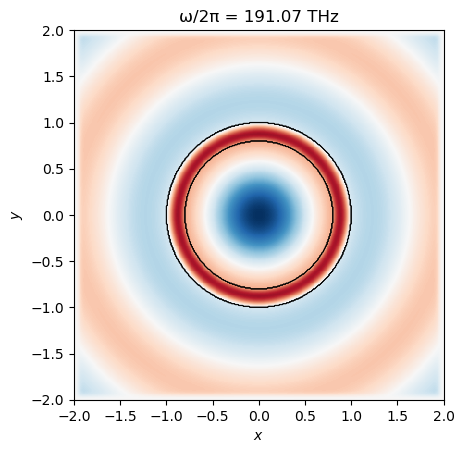

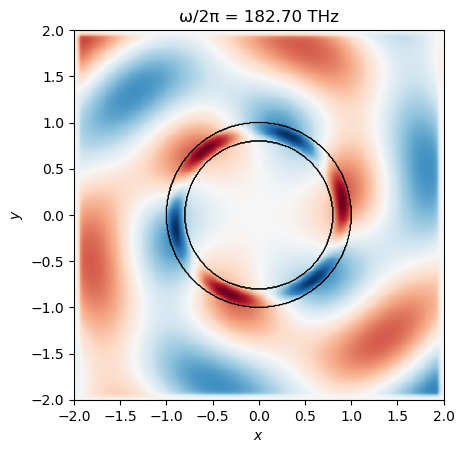

In [13]:
ax=plot_field.(fields, funcz=real)
plot_device.(ax,dev,outline=true, lc="k");

---

## Example 4: waveguide coupler

*coming soon*™

---